In [1]:
cd ../smore

/home/remedios/smore/smore


In [2]:
%load_ext autoreload
%autoreload 2

1. Load into RAM
2. Interpolate to correct digital resolution
3. For each slice:
  a. Separate into chunks (including padding + overlap indexing)
  b. Run network on each independent chunk
  c. Concatenate together into final slice
4. Reconstruct volume (in RAM for MRI and on disk for LSFM)

In [3]:
import os
import sys
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from utils.plot import *
from tqdm import tqdm
from skimage import metrics
import skimage
from resize.scipy import resize

In [4]:
fpath = Path("/home/remedios/data/ADNI/ADNI_phantom_1mm_inplane_header_corrected/SUPERRES-ADNIPHANTOM_20200711_PHANTOM-T2-TSE-2D-CORONAL-PRE-ACQ1-04mm_resampled.nii")
vol = nib.load(fpath).get_fdata(dtype=np.float32)

In [5]:
gt_fpath = Path("/home/remedios/data/ADNI/ADNI_phantom_1mm_inplane_header_corrected/SUPERRES-ADNIPHANTOM_20200711_PHANTOM-T2-TSE-2D-CORONAL-PRE-ACQ1-01mm_resampled.nii")
gt_vol = nib.load(gt_fpath).get_fdata(dtype=np.float32)
vmin = gt_vol.min()
vmax = 0.8 * gt_vol.max()

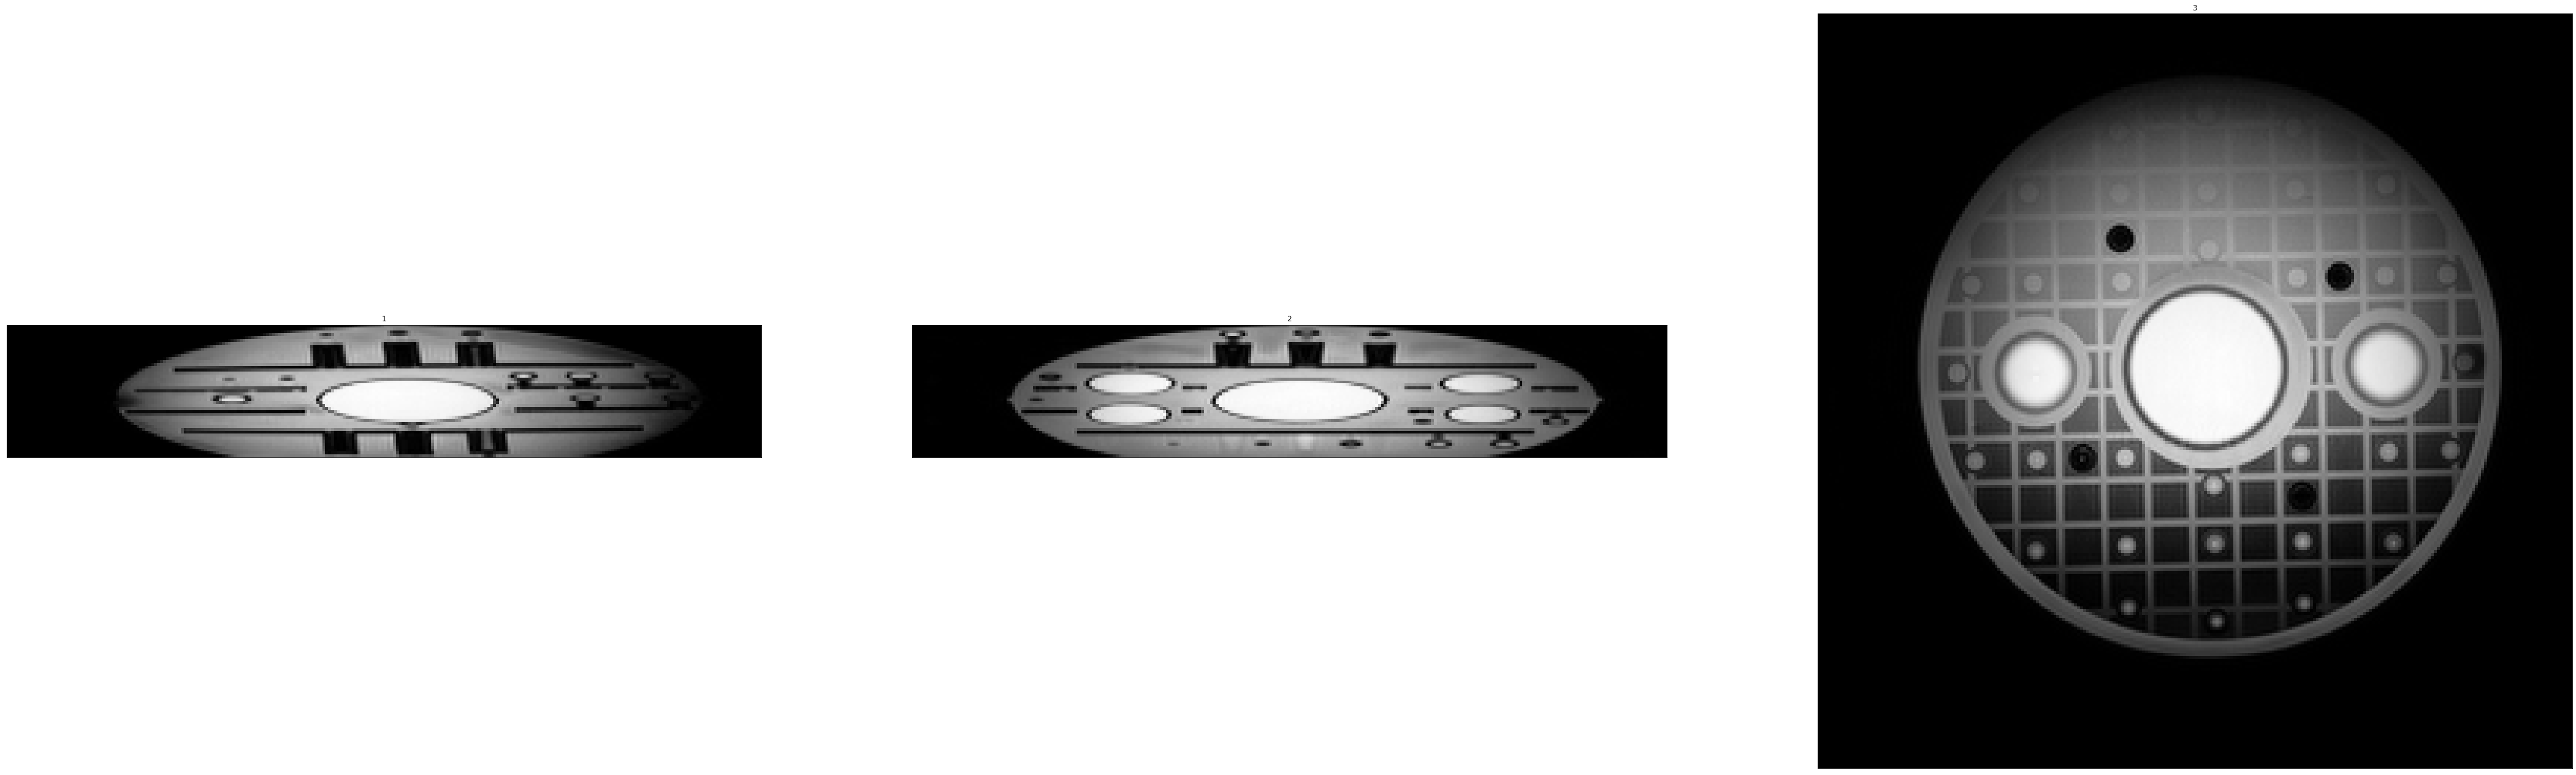

In [6]:
center_vol_plot(vol)

1. Interpolate entire volume to correct resolution

In [7]:
vol_interp = resize(vol, dxyz=(1, 1, 0.25), order=5)

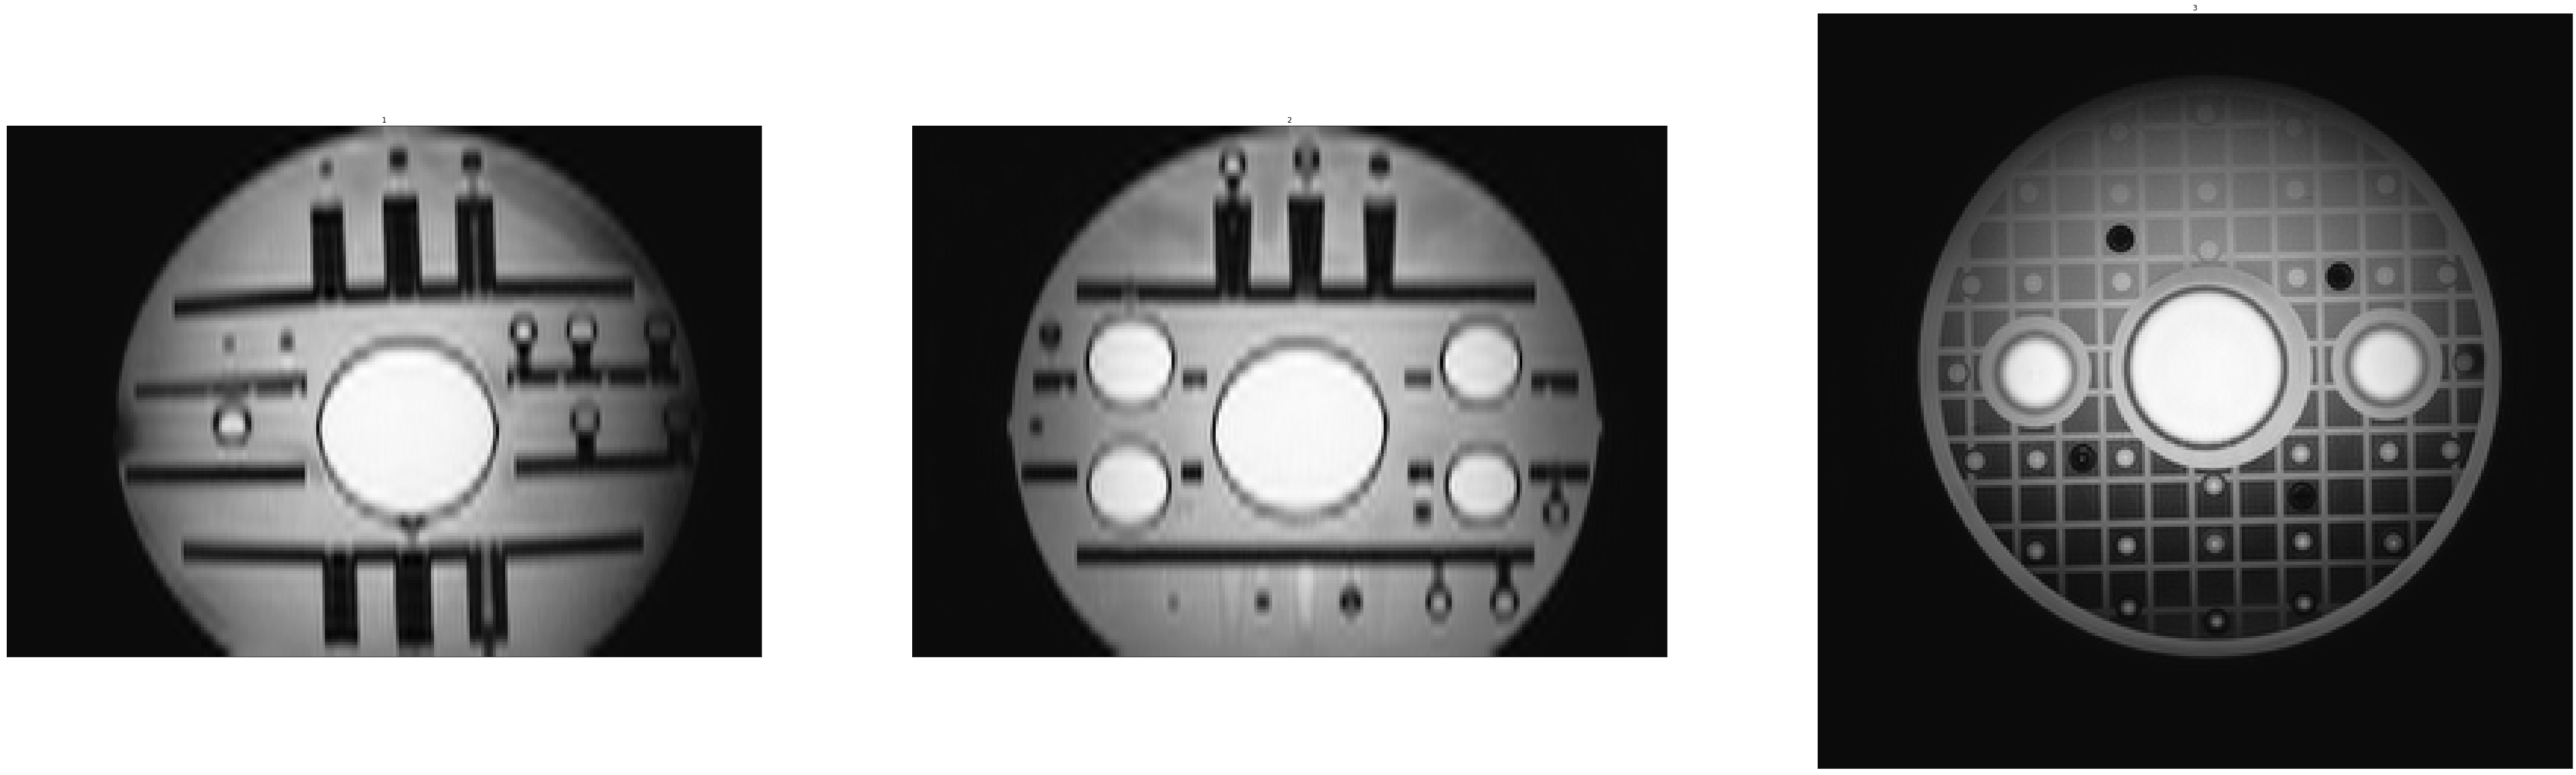

In [8]:
center_vol_plot(vol_interp)

In [9]:
vol_interp.shape

(256, 256, 180)

Load network

In [10]:
from models.net import Net
import torch

In [11]:
gpu_device = torch.device(f'cuda:0')
weight_dir = Path("../../data/results/smoreCE/SUPERRES-ADNIPHANTOM_20200711_PHANTOM-T2-TSE-2D-CORONAL-PRE-ACQ1-04mm_resampled/weights/")
checkpoint = torch.load(weight_dir / '{}_best_weights.h5'.format('SR'))
model = Net(
    n_channels=1,
    kernel_size=3,
    patch_size=64,
    n_layers=16,
    filters=256,
)
model.load_state_dict(checkpoint['model'])
model.to(gpu_device).eval()

Net(
  (head): ConvAct(
    (conv): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1))
    (act): ReLU(inplace=True)
  )
  (body): Sequential(
    (0): ConvAct(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (act): ReLU(inplace=True)
    )
    (1): ConvAct(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (act): ReLU(inplace=True)
    )
    (2): ConvAct(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (act): ReLU(inplace=True)
    )
    (3): ConvAct(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (act): ReLU(inplace=True)
    )
    (4): ConvAct(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (act): ReLU(inplace=True)
    )
    (5): ConvAct(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (act): ReLU(inplace=True)
    )
    (6): ConvAct(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (act): ReLU(inplace=True)
    )
    

# Pick a 2D slice, run entire network

In [12]:
gt_slice = gt_vol[128]

In [13]:
img = vol_interp[128]

# plt.imshow(np.rot90(img))

# First we have to pad by 16 on both sides due to network size
img = np.pad(img, ((16, 16), (16, 16)), mode='reflect')

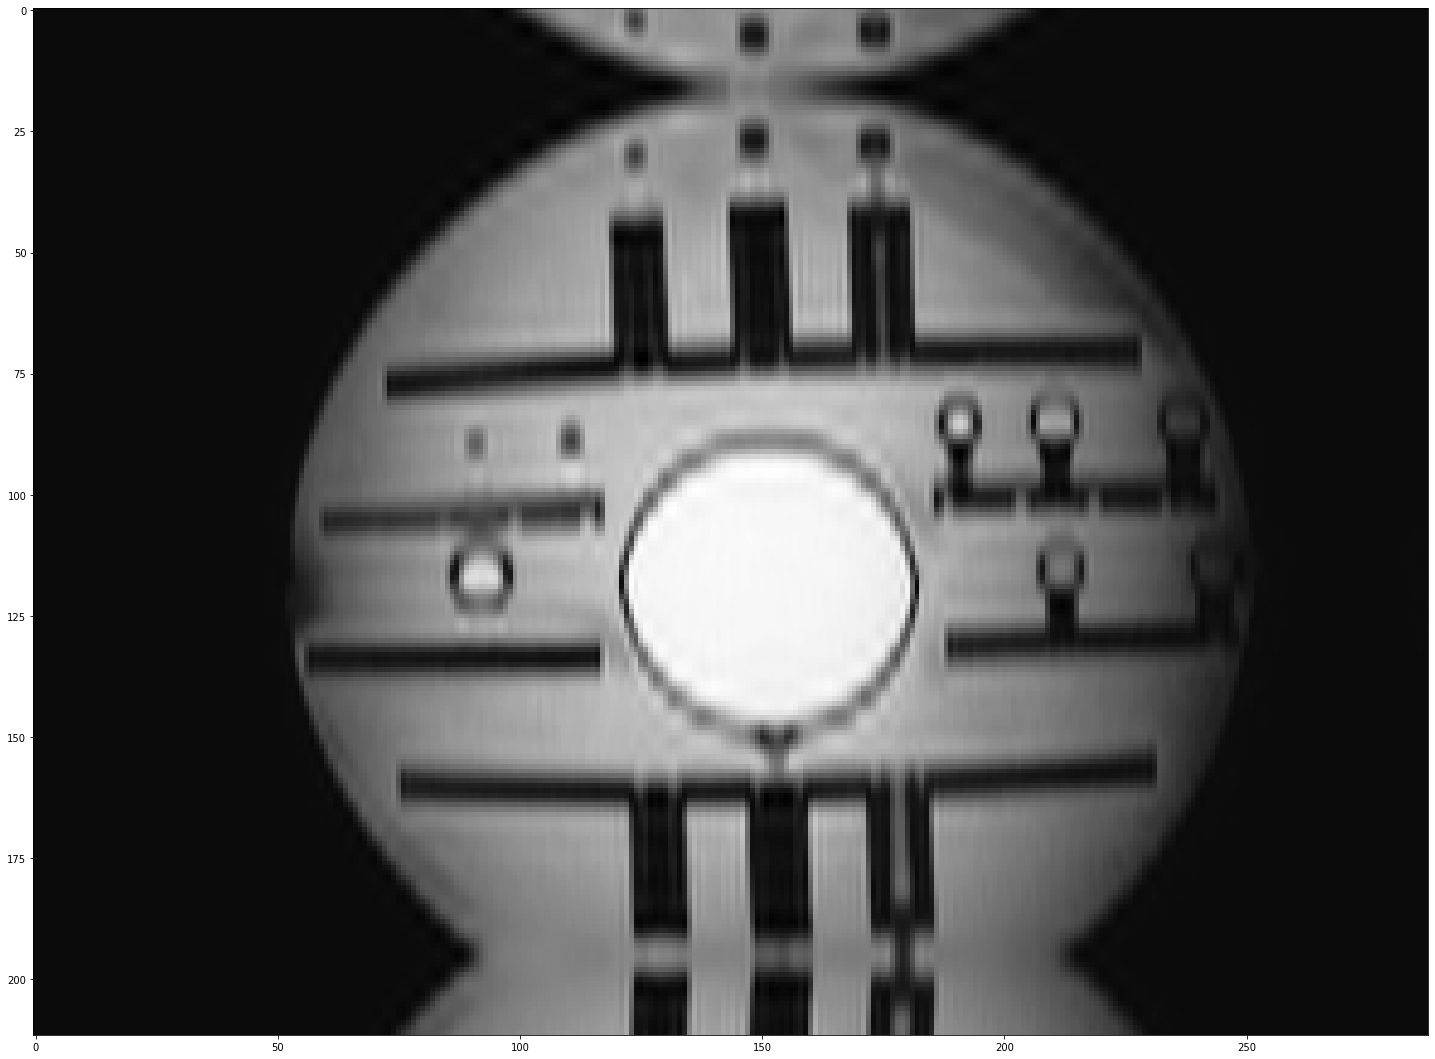

In [14]:
plt.imshow(np.rot90(img))

In [15]:
full_slice_pred = model(
    torch.from_numpy(img).unsqueeze(0).unsqueeze(1).permute(0, 1, 3, 2).to(gpu_device)
).detach().cpu().squeeze().permute(1, 0).numpy()

In [16]:
full_slice_pred.shape

(256, 180)

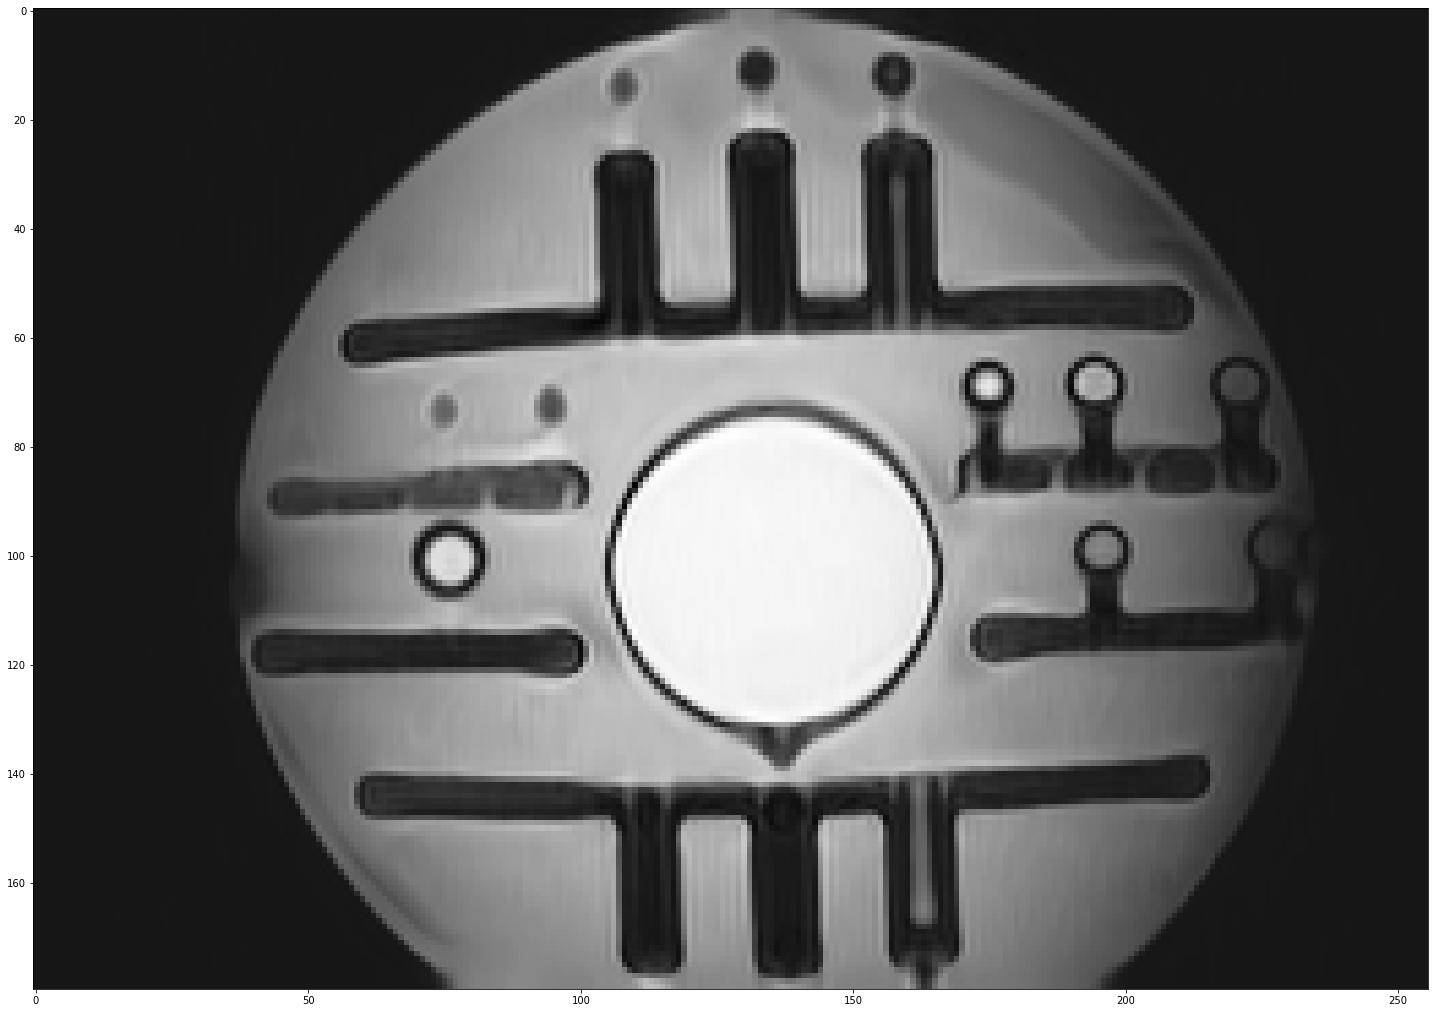

In [17]:
plt.imshow(np.rot90(full_slice_pred))

# Chunk it up

In [26]:
out = model.forward_in_chunks(img, chunk_size=64, target_shape=(256, 180), device=gpu_device)

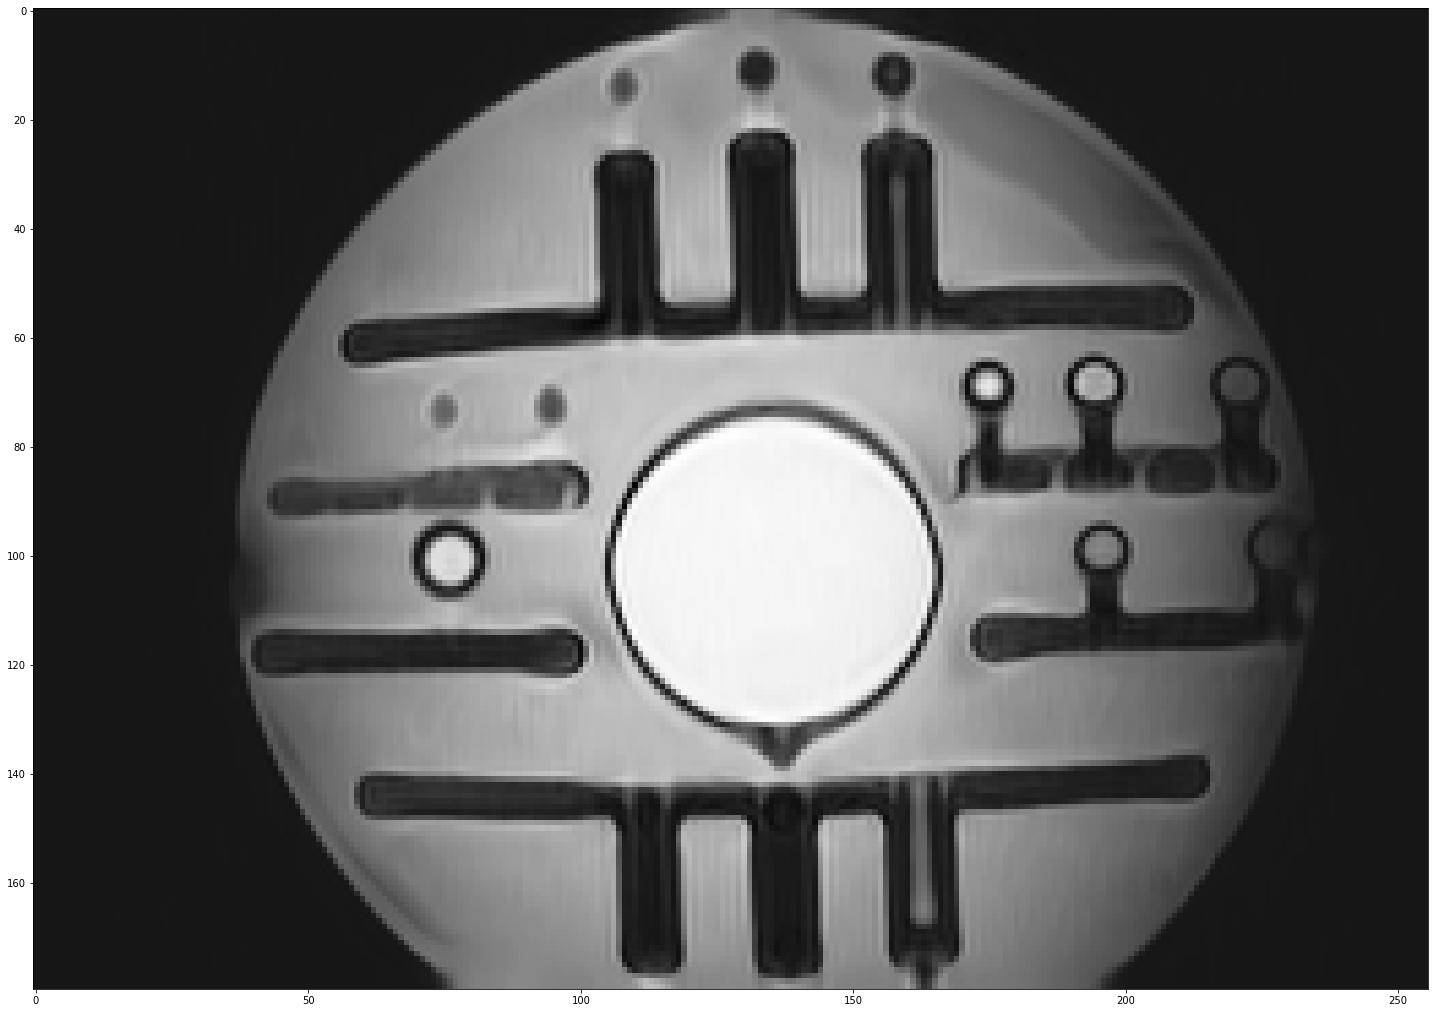

In [27]:
plt.imshow(np.rot90(out))

In [28]:
gt_slice.shape

(256, 180)

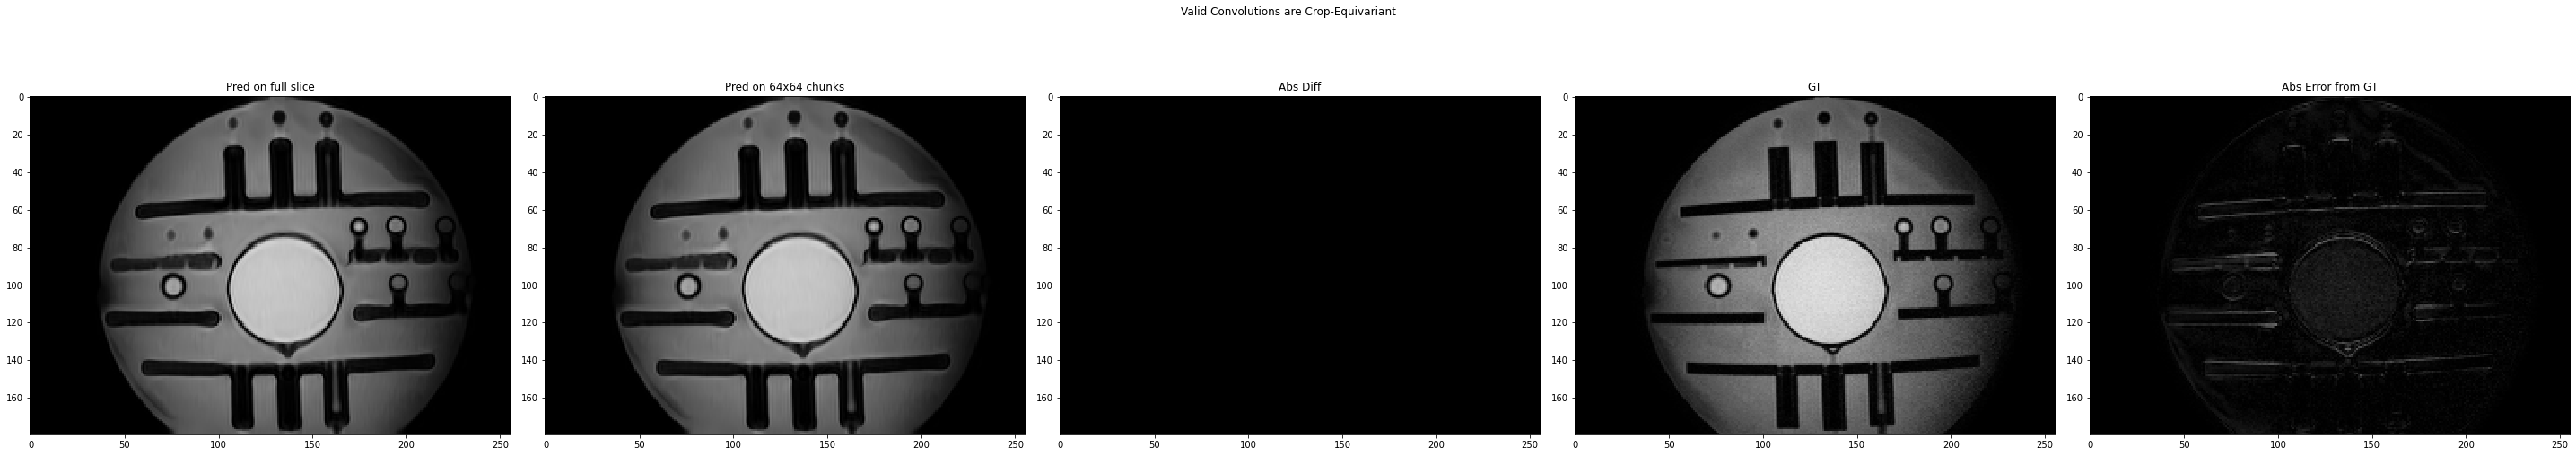

In [31]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(8*5, 8))

axs[0].imshow(np.rot90(full_slice_pred), vmin=vmin, vmax=vmax)
axs[0].set_title("Pred on full slice")
axs[1].imshow(np.rot90(out), vmin=vmin, vmax=vmax)
axs[1].set_title("Pred on 64x64 chunks")
axs[2].imshow(np.rot90(np.abs(out - full_slice_pred)), vmin=vmin, vmax=vmax)
axs[2].set_title("Abs Diff")
axs[3].imshow(np.rot90(gt_slice), vmin=vmin, vmax=vmax)
axs[3].set_title("GT")
axs[4].imshow(np.rot90(np.abs(out - gt_slice)), vmin=vmin, vmax=vmax)
axs[4].set_title("Abs Error from GT")
plt.suptitle("Valid Convolutions are Crop-Equivariant")
plt.tight_layout()
plt.show()

In [32]:
np.abs(out - gt_slice).sum() / gt_slice.sum()

0.123213425

# Compare to SMORE

In [33]:
from models.edsr import EDSR

In [35]:
edsr = EDSR(
    patch_size=32,
    n_channels=1,
    kernel_size=3,
    n_resblocks=32,
    filters=256,
    padding_mode='zeros',
    min_clip=0,
)
weight_dir = Path("../../data/results/smore3/SUPERRES-ADNIPHANTOM_20200711_PHANTOM-T2-TSE-2D-CORONAL-PRE-ACQ1-04mm_resampled/weights/")
checkpoint = torch.load(weight_dir / '{}_best_weights.h5'.format('SR'))
edsr.load_state_dict(checkpoint['model'])
edsr.to(gpu_device).eval()

EDSR(
  (head): Sequential(
    (0): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (body): Sequential(
    (0): ResBlock(
      (body): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (1): ResBlock(
      (body): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (2): ResBlock(
      (body): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (3): ResBlock(
      (body): Sequential(
        (0): Conv2d(256, 256, kernel_si

In [36]:
edsr_full_slice_pred = edsr(
    torch.from_numpy(img).unsqueeze(0).unsqueeze(1).permute(0, 1, 3, 2).to(gpu_device)
).detach().cpu().squeeze().permute(1, 0).numpy()
edsr_full_slice_pred = edsr_full_slice_pred[16:-16, 16:-16]

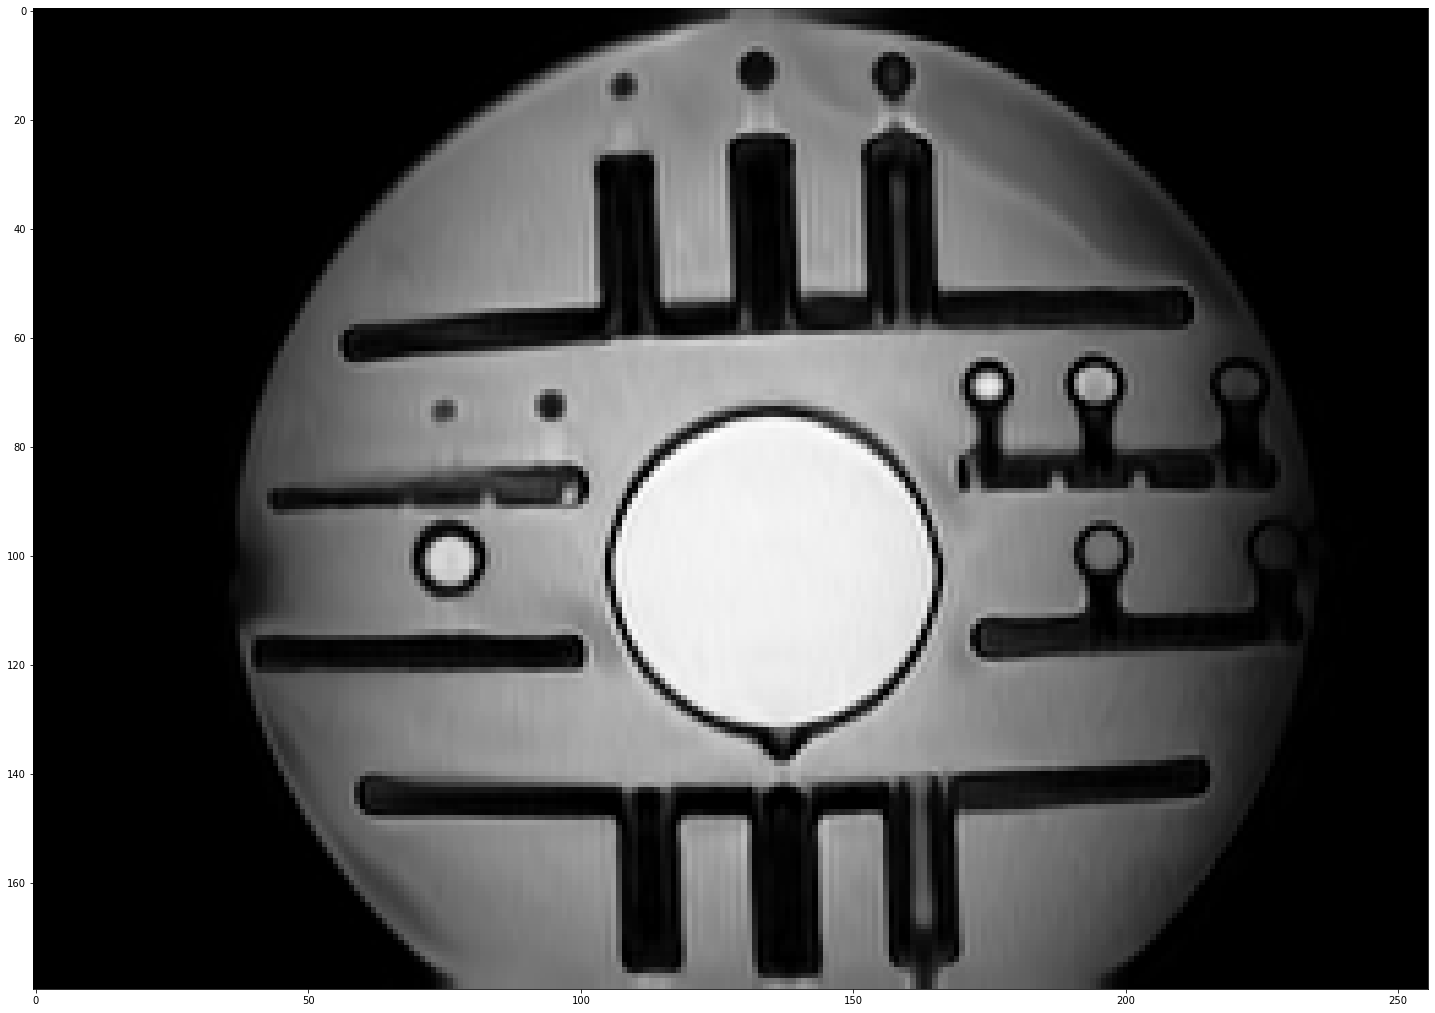

In [37]:
plt.imshow(np.rot90(edsr_full_slice_pred))

In [38]:
# edsr_out = np.zeros((256, 180))
# for i in range(0, img.shape[0], 32):
#     for j in range(0, img.shape[1], 32):
#         chunk = img[i:i+64, j:j+64]
        
#         pads = [(np.abs(a - b) // 2, np.abs(a - b) // 2)
#                for a, b in zip(chunk.shape, (64, 64))]
#         crops = [slice(p[0], -p[1]) for p in pads]
#         crops = [c if c != slice(0, 0) else slice(None, None) for c in crops]
#         crops = tuple(crops)
#         # Pad chunk if necessary
#         chunk = np.pad(chunk, pads, mode='reflect')
#         # Run network
#         chunk_pred = edsr(
#             torch.from_numpy(chunk).permute(1, 0).unsqueeze(0).unsqueeze(1).to(gpu_device)
#         ).detach().cpu().squeeze().permute(1, 0).numpy()
        
#         chunk_pred = chunk_pred[16:-16, 16:-16]
        
#         # Crop if necessary
#         chunk_pred = chunk_pred[crops]
#         # Concatenate results to the right spot
#         edsr_out[i:i+32, j:j+32] = chunk_pred
        
# #         fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 4))
# #         axs[0].imshow(np.rot90(chunk))
# #         axs[1].imshow(np.rot90(chunk_pred))
# #         plt.show()
# #         plt.close(fig)
# #         plt.clf()

In [42]:
edsr_out = edsr.forward_in_chunks(img, chunk_size=64, target_shape=(256, 180), device=gpu_device)

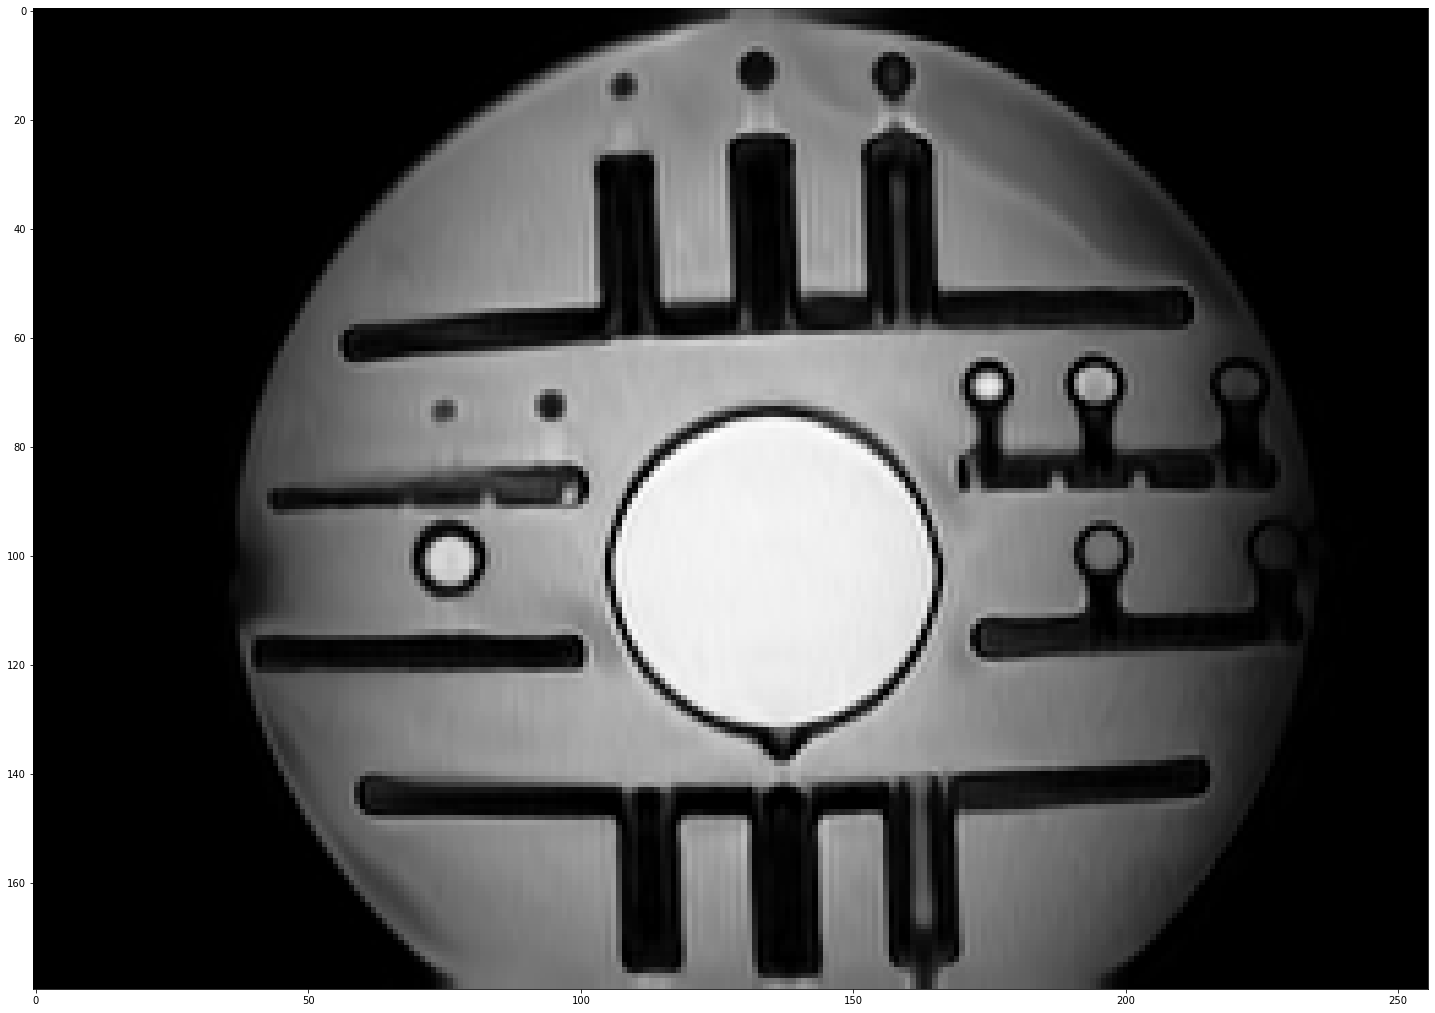

In [43]:
plt.imshow(np.rot90(edsr_out))

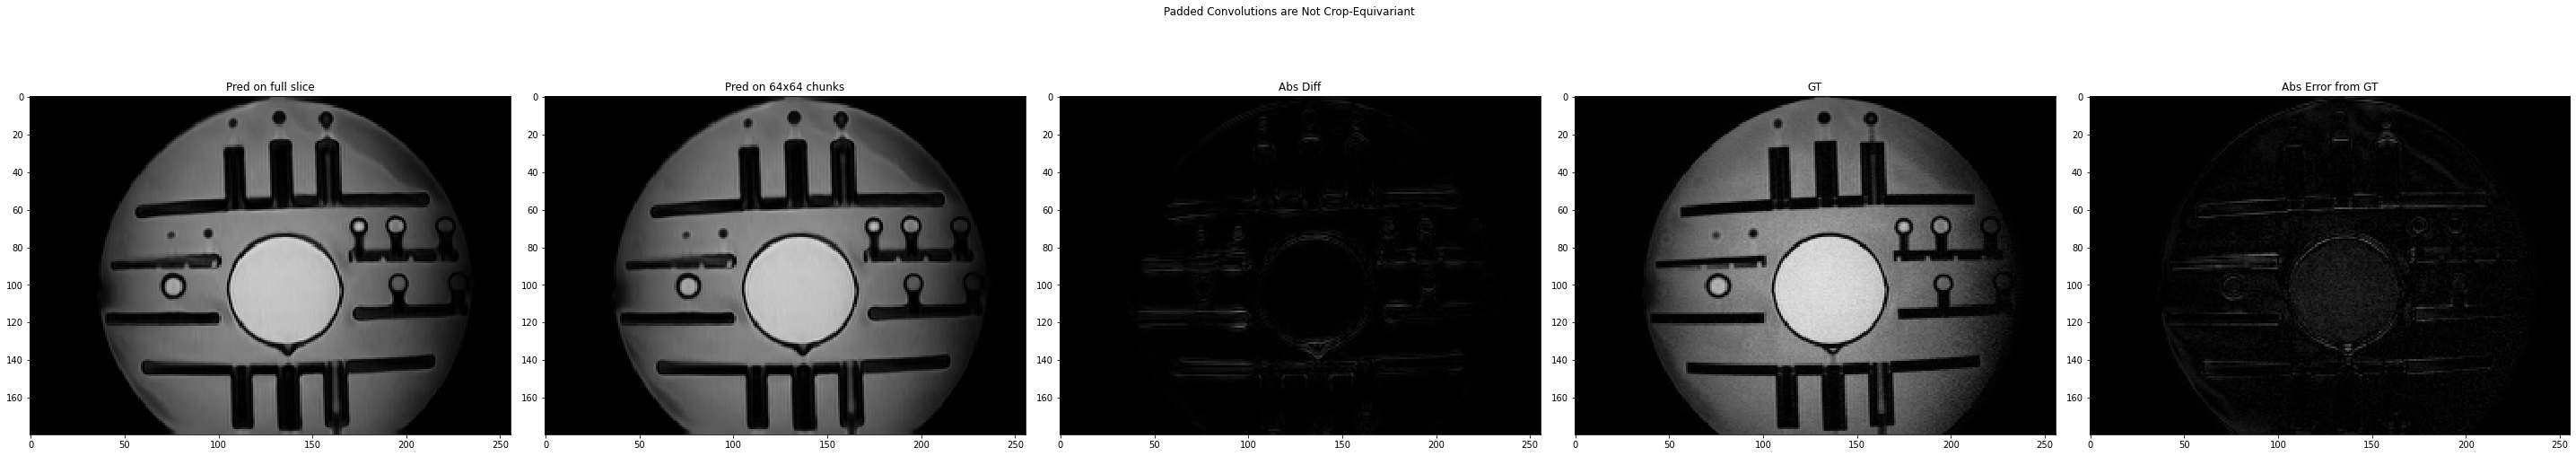

In [44]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(8*5, 8))

axs[0].imshow(np.rot90(edsr_full_slice_pred), vmin=vmin, vmax=vmax)
axs[0].set_title("Pred on full slice")
axs[1].imshow(np.rot90(edsr_out), vmin=vmin, vmax=vmax)
axs[1].set_title("Pred on 64x64 chunks")
axs[2].imshow(np.rot90(np.abs(edsr_out - full_slice_pred)), vmin=vmin, vmax=vmax)
axs[2].set_title("Abs Diff")
axs[3].imshow(np.rot90(gt_slice), vmin=vmin, vmax=vmax)
axs[3].set_title("GT")
axs[4].imshow(np.rot90(np.abs(edsr_out - gt_slice)), vmin=vmin, vmax=vmax)
axs[4].set_title("Abs Error from GT")
plt.suptitle("Padded Convolutions are Not Crop-Equivariant")
plt.tight_layout()
plt.show()

In [45]:
np.abs(edsr_out - gt_slice).sum() / gt_slice.sum()

0.109984405